In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

from venn import venn, pseudovenn
import seaborn as sns

from Bio import SeqIO, SeqUtils

from addict import Dict

import math

In [4]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

import proteomics_functions as prot_fun

(<Figure size 100x100 with 1 Axes>, <AxesSubplot:>)

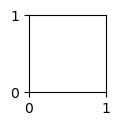

In [5]:
my_plot.instantiate_fig(1, 1)

In [6]:
df_reviewed = pd.read_csv('./generated_tables/difficult_to_remove_reviewed_2.csv')

df_reviewed.rename(columns={'std_hccf_feed':'Standard HCCF Feed', 'std_hccf_large':'Standard HCCF Large agg.', 'std_hccf_small':'Standard HCCF Small agg.', 
                          'std_hccf_mab':'Standard HCCF mAb', 'std_hccf_lmw1':'Standard HCCF SPF 1', 'std_hccf_lmw2':'Standard HCCF SPF 2', 
                          'native_hccf_feed':'Native HCCF Feed', 'native_hccf_large':'Native HCCF Large agg.', 'native_hccf_small':'Native HCCF Small agg.', 
                          'native_hccf_mab':'Native HCCF mAb', 'native_hccf_lmw1':'Native HCCF SPF 1', 
                          'std_pafvin_feed':'Standard PAVIN Feed', 'std_pafvin_large':'Standard PAVIN Large agg.', 'std_pafvin_small':'Standard PAVIN Small agg.', 
                          'std_pafvin_mab':'Standard PAVIN mAb', 
                          'native_pafvin_feed':'Native PAVIN Feed', 'native_pafvin_large':'Native PAVIN Large agg.', 'native_pafvin_small':'Native PAVIN Small agg.', 
                          'native_pafvin_mab':'Native PAVIN mAb',                        
                          'pI_mean':'pI', 'cysteine_cont_percent_mean':'Cysteine content [%]',
                           'cysteine_num_mean':'Cysteine residues'}, inplace=True)

In [7]:
df_locs = df_reviewed[['Native HCCF Feed', 'Standard HCCF Feed', 'Native HCCF Large agg.', 'Standard HCCF Large agg.', 
                         'Native HCCF Small agg.', 'Standard HCCF Small agg.', 'Native HCCF mAb', 'Standard HCCF mAb', 
                         'Native HCCF SPF 1', 'Standard HCCF SPF 1', 'Standard HCCF SPF 2',                       
                         'Native PAVIN Feed', 'Standard PAVIN Feed', 'Native PAVIN Large agg.', 'Standard PAVIN Large agg.', 
                         'Native PAVIN Small agg.', 'Standard PAVIN Small agg.', 'Native PAVIN mAb', 'Standard PAVIN mAb', 'name']]

df_locs.set_index('name', inplace=True)
df_reviewed.set_index('name', inplace=True)

df_locs_native = df_locs[[c for c in df_locs.columns if 'Native' in c]].copy()
df_locs_std = df_locs[[c for c in df_locs.columns if 'Standard' in c]].copy()

for c in df_locs_native.columns:
    df_locs_native[c] = df_locs_native[c].map({False:0, True:1})
for c in df_locs_std.columns:
    df_locs_std[c] = df_locs_std[c].map({False:0, True:0.5})
    
df_locs_2 = df_locs_native.merge(df_locs_std, left_index=True, right_index=True)

df_locs_2 = df_locs_2[['Native HCCF Feed', 'Standard HCCF Feed', 'Native HCCF Large agg.', 'Standard HCCF Large agg.', 
                         'Native HCCF Small agg.', 'Standard HCCF Small agg.', 'Native HCCF mAb', 'Standard HCCF mAb', 
                         'Native HCCF SPF 1', 'Standard HCCF SPF 1', 'Standard HCCF SPF 2',                       
                         'Native PAVIN Feed', 'Standard PAVIN Feed', 'Native PAVIN Large agg.', 'Standard PAVIN Large agg.', 
                         'Native PAVIN Small agg.', 'Standard PAVIN Small agg.', 'Native PAVIN mAb', 'Standard PAVIN mAb']]

In [8]:
papers = ['Biophorum DTR', 'Biophorum high-risk', 'Levy 2014 - Association', 'Aboulaich 2014 - Association', 'Zhang 2016 - Pro A', 
          'Levy 2016 - Coelution', 'Molden 2021 - 29 DS', 'Falkenberg 2019 - 6 DS', 'Kreimer 2017 - 1 DS']

df_reviewed.fillna(value=False, inplace=True)

for i, cont in df_reviewed.iterrows():
    for paper in papers:
        if cont[paper]:
            df_reviewed.at[i, paper] = True
        else:
            pass
        
for paper in papers:
    df_reviewed[paper] = df_reviewed[paper].astype(bool, copy=False)

In [9]:
cmap_cluster = matplotlib.colors.ListedColormap(['white', 'tab:orange', 'tab:blue'])
norm_cluster = BoundaryNorm([0, 0.25, 0.75, 1], cmap_cluster.N)

for i, paper in enumerate(papers):
    if i == 0:
        row_colors = prot_fun.map_binary_colorbar(df_reviewed[paper], color=f'C{i+2}')
    elif i == 8:
        row_colors = prot_fun.map_binary_colorbar(df_reviewed[paper], color='magenta', row_colors=row_colors)
    else:
        row_colors = prot_fun.map_binary_colorbar(df_reviewed[paper], color=f'C{i+2}', row_colors=row_colors)

In [10]:
row_colors.columns = ['Biophorum difficult-to-remove', 'Biophorum high-risk', 'Aboulaich 2014 - mAb association', 'Levy 2014 - mAb association', 'Zhang 2016 - Co-purification in Pro A', 
                      'Levy 2016 - Coelution in polishing', 'Molden 2021 - In one of 29 DS', 'Falkenberg 2019 - In 5/6 DS', 'Kreimer 2017 - In DS']

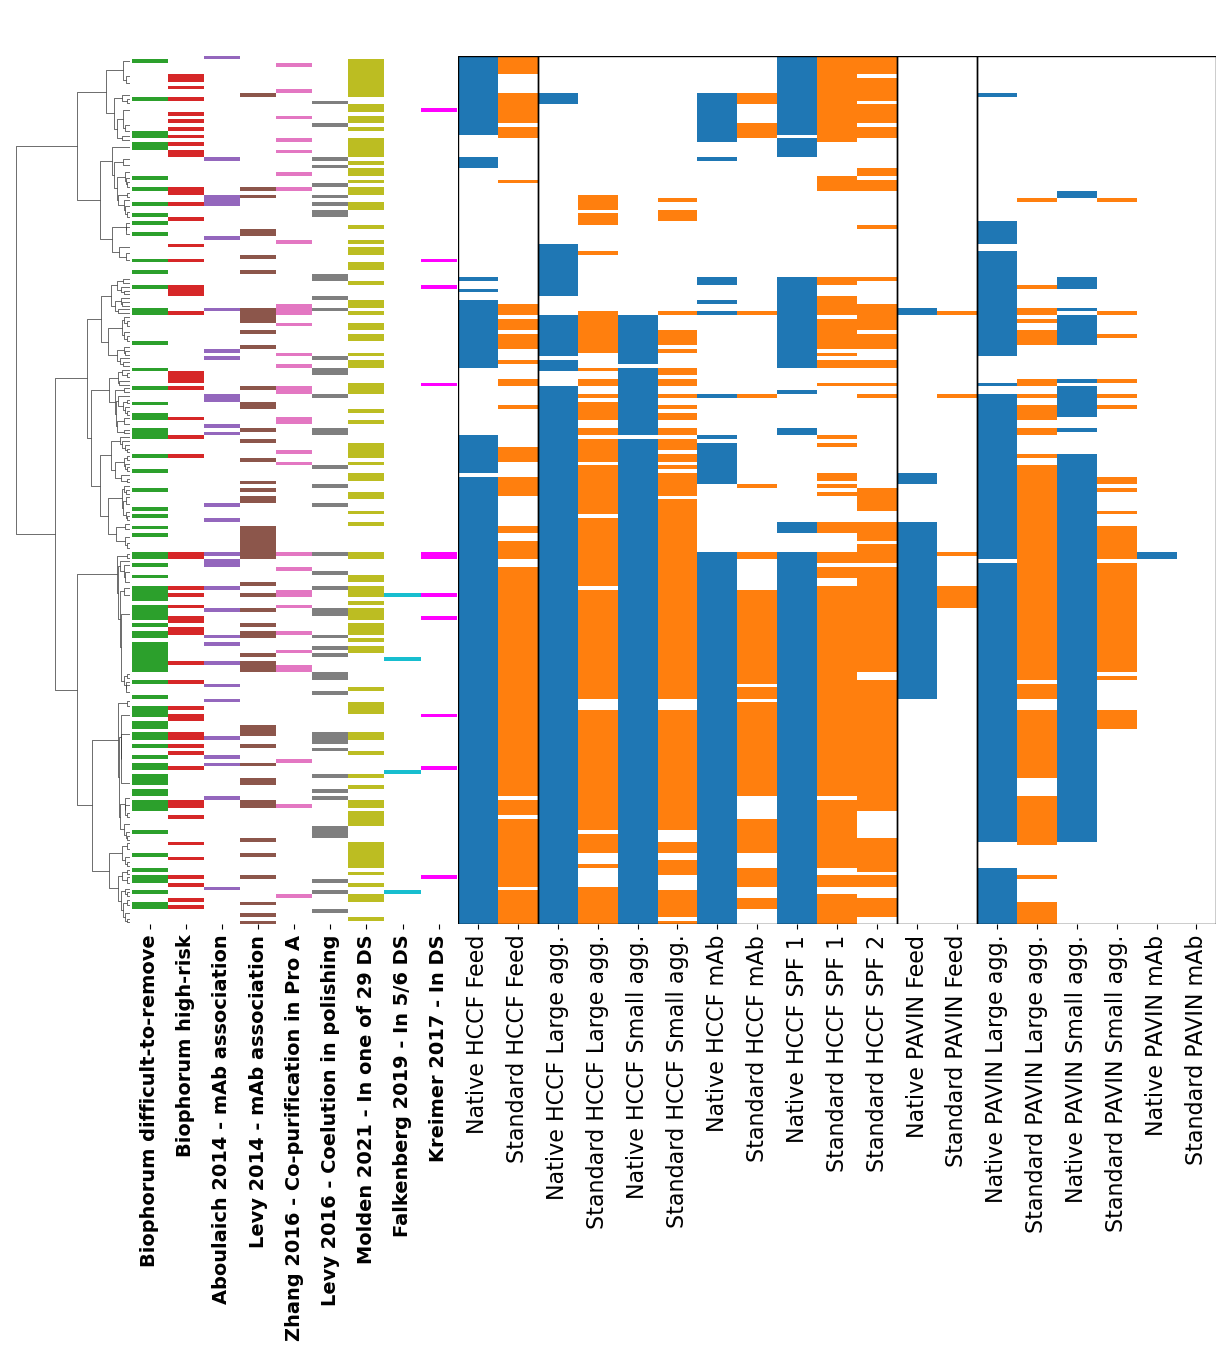

In [12]:
ax = sns.clustermap(df_locs_2, row_colors=row_colors, cmap=cmap_cluster, norm=norm_cluster, method='ward',
                    cbar_pos=None, dendrogram_ratio=(0.1, 0.05), figsize=(13, 15), yticklabels=False, col_cluster=False)

fontsize = 16
rotation = 90

# Set row color label 
ax_row_colors = ax.ax_row_colors
ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=fontsize-2, weight='bold')

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Add rectangles
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((0, 0), 2, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((2, 0), 9, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((11, 0), 2, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((13, 0), 6, len(df_locs_2), fill=False, edgecolor='black', lw=1))

ax.savefig(f'./images/6_clustermap_DTR.png', dpi=300)
ax.savefig(f'./images/6_clustermap_DTR.tif', dpi=300)
ax.savefig(f'./images/6_clustermap_DTR.eps', dpi=300)

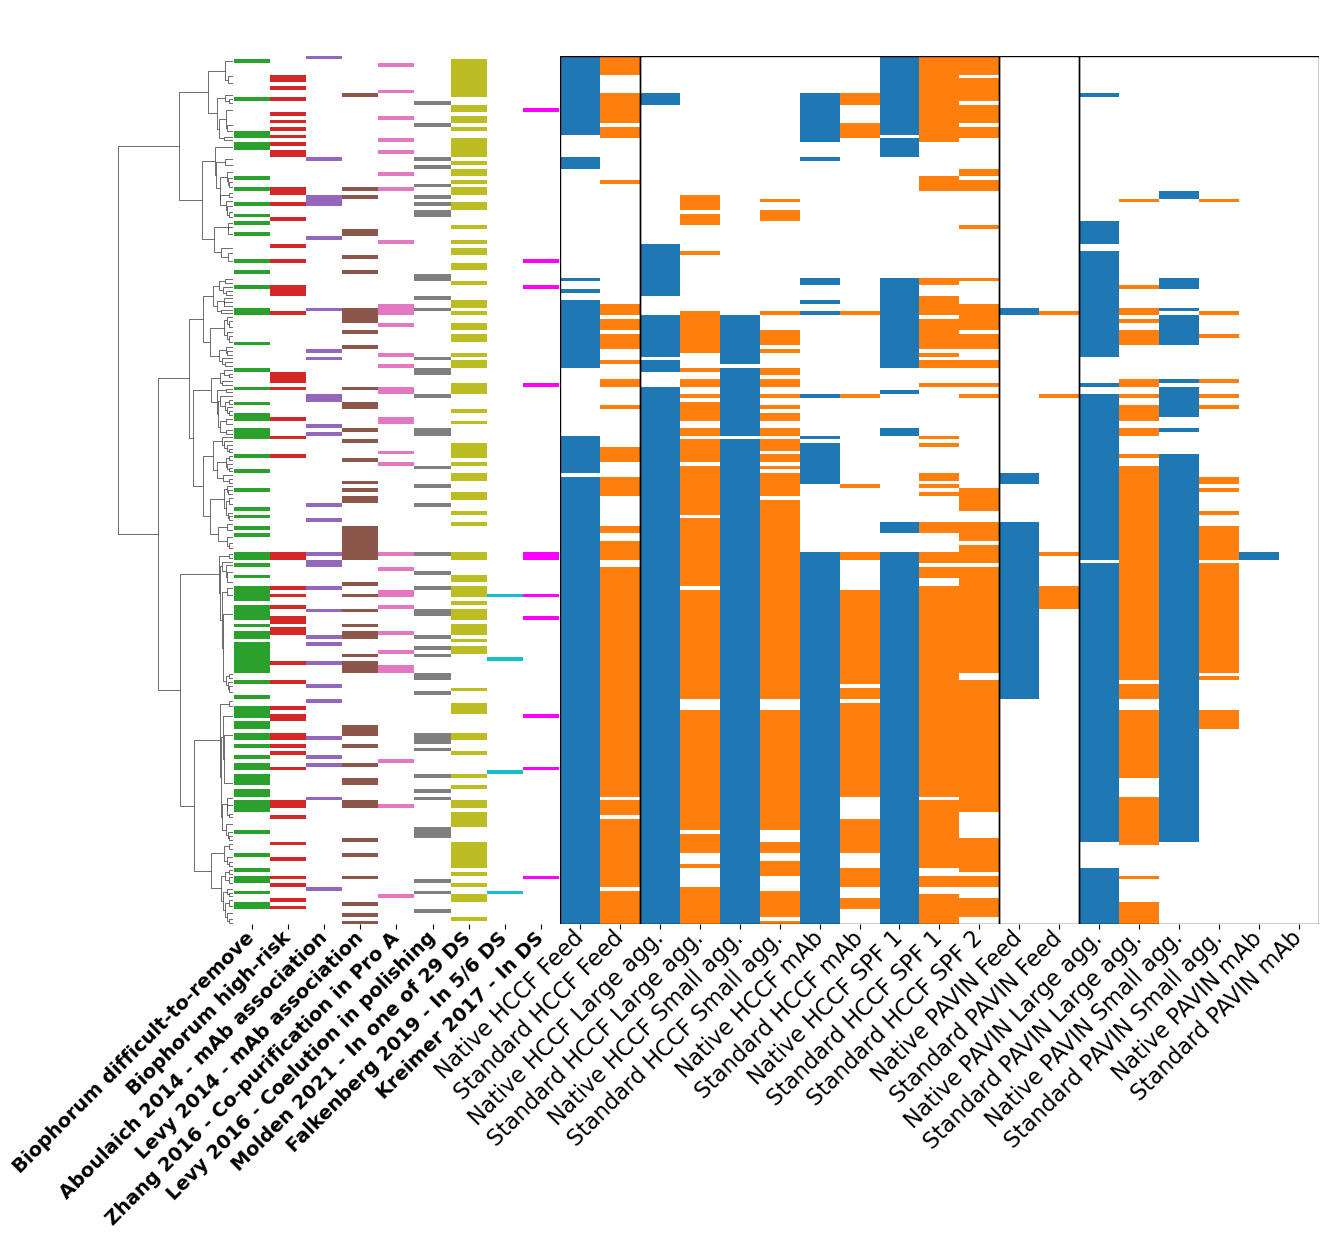

In [12]:
ax = sns.clustermap(df_locs_2, row_colors=row_colors, cmap=cmap_cluster, norm=norm_cluster, method='ward',
                    cbar_pos=None, dendrogram_ratio=(0.1, 0.05), figsize=(13, 15), yticklabels=False, col_cluster=False)

fontsize = 16
rotation = 45

# Set row color label 
ax_row_colors = ax.ax_row_colors
ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=fontsize-2, weight='bold')

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Add rectangles
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((0, 0), 2, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((2, 0), 9, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((11, 0), 2, len(df_locs_2), fill=False, edgecolor='black', lw=1))
r = heat.add_patch(Rectangle((13, 0), 6, len(df_locs_2), fill=False, edgecolor='black', lw=1))

ax.savefig(f'./images/6_clustermap_DTR_rotated_tick_labels.png', dpi=300)